In [154]:
import time
start = time.time()

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label 
import cv2 

In [155]:
# input nii image from the prediction 
input_path = 'F:/Xiangping/498/osfstorage-archive/predTs/'
image_name = 'reslice.nii.gz'
input_image = nib.load(input_path + image_name)
image_raw = input_image.get_fdata()

In [156]:
# change the ordering of the data to fit cartesian coords
# check the projections to alline Matlab code
[xx, yy, zz] = input_image.shape
CT = np.zeros((yy,xx,zz))
for x in range(xx):
    for y in range(yy):
        for z in range(zz):
            CT[y,x,z] = image_raw[x, y, z]
# # create projections 
# YZproj = np.sum(CT, axis=0)
# XZproj = np.sum(CT, axis=1)
# XYproj = np.sum(CT, axis=2)
# plt.imshow(YZproj, cmap='viridis', interpolation='nearest', aspect='auto')
# plt.imshow(CT[200,:,:], cmap='gray')
# plt.show()

In [157]:
# for all the frame, find the frame with the largest predicted bone area 
[xx, yy, zz] = CT.shape 
area = []
for z in range(zz):
    area.append(np.sum(CT[:,:,z])) 
frame_area = max(area)
frame = area.index(frame_area)

In [158]:
# find the top two largest connected components, which are the two trackers 
image = CT[:,:,frame]

def swap(a, b):
    temp = a 
    a = b 
    b = temp 
    return a, b

# return the center of mass of two trackers 
# number: the tracker number, process with 1 and 2, others will return the largestCC and secondCC
def get_tracker(image, number):
    labels = label(image)
    largest = labels == np.argmax(np.bincount(labels.flat)[1:])+1   # tracker 1
    CC = image.copy() - largest
    labels = label(CC)
    second = labels == np.argmax(np.bincount(labels.flat)[1:])+1    # tracker 2 
    
    # find the center of mass of two trackers 
    largest_massx = np.average(largest, axis=0).tolist()
    largest_massy = np.average(largest, axis=1).tolist() 
    largest_x = largest_massx.index(max(largest_massx))
    largest_y = largest_massy.index(max(largest_massy))
    
    second_massx = np.average(second, axis=0).tolist()
    second_massy = np.average(second, axis=1).tolist() 
    second_x = second_massx.index(max(second_massx))
    second_y = second_massy.index(max(second_massy))

    # assume two trackers are in the top and bottom location, 
    # define the top tracker as the largest, the bottom one as second largest 
    if largest_y > second_y:
        largest, second = swap(largest, second) 
        largest_x, second_x = swap(largest_x, second_x) 
        largest_y, second_y = swap(largest_y, second_y) 

    if number == 1:
        return (largest_x, largest_y) 
    elif number == 2:
        return (second_x, second_y)
    else:
        return largest+[1]-[1], second+[1]-[1]

# return the images of both trackers: largest, second
# the center of mass of both trackers: (largest_x, largest_y), (second_x, second_y) 
def get_all_information(image):
    largest, second = get_tracker(image, 0)
    largest_x, largest_y = get_tracker(image, 1)
    second_x, second_y = get_tracker(image, 2)
    return largest, second, largest_x, largest_y, second_x, second_y

largest, second, largest_x, largest_y, second_x, second_y = get_all_information(image)
bone_image = image - largest - second

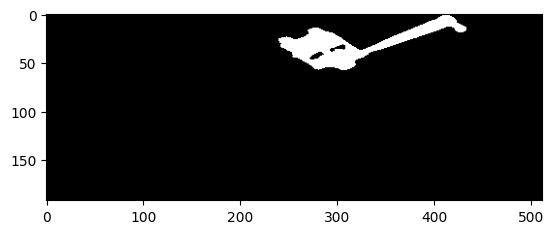

In [159]:
plt.imshow(largest, cmap='gray')

In [160]:
# do the same thing for two neighbor frames to average the noise 
if (frame-2) > 0 and (frame+2) < CT.shape[2]-1:
    print("get neighbor")
    left1 = CT[:,:,frame-1]
    largest_left1, second_left1, largest_x_left1, largest_y_left1, second_x_left1, \
        second_y_left1 = get_all_information(left1)
    left2 = CT[:,:,frame-2]
    largest_left2, second_left2, largest_x_left2, largest_y_left2, second_x_left2, \
        second_y_left2 = get_all_information(left2)
    right1 = CT[:,:,frame+1]
    largest_right1, second_right1, largest_x_right1, largest_y_right1, second_x_right1, \
        second_y_right1 = get_all_information(right1)
    right2 = CT[:,:,frame+2]
    largest_right2, second_right2, largest_x_right2, largest_y_right2, second_x_right2, \
        second_y_right2 = get_all_information(right2)

    largest_average = (largest + largest_left1 + largest_left2 + largest_right1 + \
                    largest_right2)/5
    second_average = (second + second_left1 + second_left2 + second_right1 + \
                    second_right2)/5
    largest_x_average = (largest_x + largest_x_left1 + largest_x_left2 + largest_x_right1 + \
                    largest_x_right2)/5
    largest_y_average = (largest_y + largest_y_left1 + largest_y_left2 + largest_y_right1 + \
                    largest_y_right2)/5
    second_x_average = (second_x + second_x_left1 + second_x_left2 + second_x_right1 + \
                    second_x_right2)/5
    second_y_average = (second_y + second_y_left1 + second_y_left2 + second_y_right1 + \
                    second_y_right2)/5
    image_average = (left1 + left2 + right1 + right2 + image)/5

    bone_image = image_average - largest_average - second_average

bone_image_copy = bone_image.copy()
# plt.imshow(bone_image_copy, cmap='gray')

get neighbor


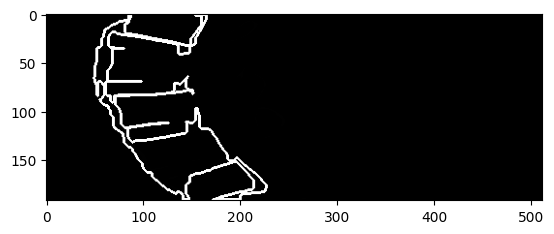

In [161]:
# detect the outline of the bone 
bone_image = np.uint8(bone_image*255)

# blur the image vertically to connect all the bones
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,10))
morph = cv2.morphologyEx(bone_image, cv2.MORPH_CLOSE, kernel)

# edges = cv2.Canny(bone_image, 0, 1, apertureSize = 3)

contours, hierarchy = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

# Filter out small contours (noise)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]

assert len(contours) == 2, "Fail to detect large bone piece, \
    please change the blur kernel size and try again. "
# the second largest contour is the main bone as the small bone contain the bone area, 
# but the large bone should be only contain the outline, resulting in a small area 
bone_contour = contours[1]

cv2.drawContours(bone_image_copy, bone_contour, -1, 255, 2)
plt.imshow(bone_image_copy, cmap='gray')
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,2))
# bone = cv2.morphologyEx(bone_image_copy, cv2.MORPH_OPEN, kernel)
# plt.imshow(bone, cmap='gray')


27 121


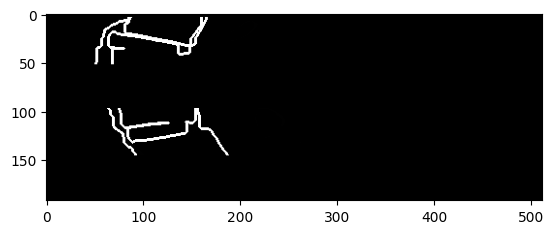

In [162]:
# find the line whose x axis is closest to the center of mass 
print(largest_y, second_y)  # track position, only keep nearby lines
# need ball information 

boundary = 25
largest_boundary = [largest_y-boundary, largest_y+boundary]
second_boundary = [second_y-boundary, second_y+boundary]
yy,xx = bone_image_copy.shape
for y in range(yy):
    if (y > largest_boundary[0] and y < largest_boundary[1]) or \
        (y > second_boundary[0] and y < second_boundary[1]):
        continue
    else: 
        bone_image_copy[y,:] = np.zeros(xx)
bone_image_copy1 = bone_image_copy.copy()
bone_image_copy1[bone_image_copy<200] = 0
bone_image_copy1[bone_image_copy>=200] = 1
bone_image_copy1 = bone_image_copy1.astype('uint8')

plt.imshow(bone_image_copy, cmap='gray')
    

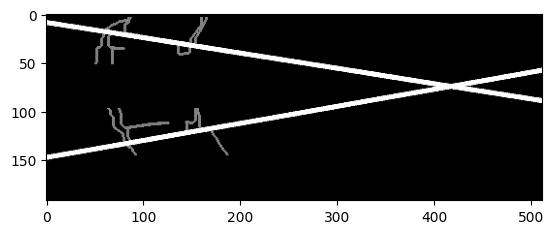

In [163]:
# find the center of mass of each line and pick the line whose y axis closest to the two tracks 
from skimage.transform import hough_line, hough_line_peaks

hspace, angles, dists = hough_line(bone_image_copy1[0:yy//2,:])
hspace, angles_top, dists_top = hough_line_peaks(hspace, angles, dists)
hspace, angles, dists = hough_line(bone_image_copy1[yy//2:yy,:])
hspace, angles_bot, dists_bot = hough_line_peaks(hspace, angles, dists)

bone_image_copy = bone_image_copy1.copy()
m = []

def find_lines(angles, dists, bone_image_copy, position):
    rho = dists[0]
    theta = angles[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho + position
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(bone_image_copy, pt1, pt2, 2, 3, cv2.LINE_AA)
    m.append(theta)

find_lines(angles_top, dists_top, bone_image_copy, 0)
find_lines(angles_bot, dists_bot, bone_image_copy, yy//2)

plt.imshow(bone_image_copy, cmap='gray')

In [166]:
# plt.imshow(bone_image_copy1, cmap='gray')
m2,m1 = m
m1 = math.tan(m1)
m2 = math.tan(m2)
import math
angle = math.atan((m2-m1)/(1+m1*m2))
print(math.degrees(angle))

18.999999999999996


In [165]:
end = time.time()
print(end-start)

15.282924890518188
